In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image, ImageFile
import tensorflow as tf
import json
import glob
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import gradio as gr
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [ ]:
import pathlib
dataset_path = "./xBD-dataset"
train_data_dir = pathlib.Path(dataset_path+"/train/images")
test_data_dir = pathlib.Path(dataset_path+"/test/images")

train_files = glob.glob(r""+dataset_path+"/train/images/*.png")
train_files = random.sample(train_files, 1500)
train_datasize = len(train_files)
print("training data:", len(train_files))

test_files = glob.glob(r""+dataset_path+"/test/images/*.png")
test_files = random.sample(test_files, 500)
test_datasize = len(test_files)
print("test data:", len(test_files))

training data: 1500
test data: 500


In [ ]:
images = list(train_data_dir.glob('*'))
random_image = random.choice(images)
im = PIL.Image.open(str(random_image))

width, height = im.size
print(width)
print(height)
im.resize((300, 300)).show()

1024
1024


In [ ]:
img_height = 1024
img_width = 1024
class_names = np.array(sorted(['disaster happened', 'no disaster happened']))
print(class_names)

['disaster happened' 'no disaster happened']


In [ ]:
def get_label(file_path, type):
    parts = file_path.split(os.path.sep)


    if "pre" in parts[7]:
      damage = 'no disaster happened'
    else: # "post"
      damage = 'disaster happened'

    label = damage == class_names
    one_hot = np.zeros(len(class_names), dtype=np.uint8)
    one_hot[label] = 1

    return one_hot


def get_label_from_one_hot(array):
    return class_names[np.where(array == 1)]

In [ ]:
train_X = np.zeros((train_datasize, img_height, img_width, 3), dtype=np.uint8)
train_Y = np.zeros((train_datasize, len(class_names)), dtype=np.uint8)

for i in range(len(train_files)):
    img= PIL.Image.open(train_files[i])
    train_X[i] = np.array(img)
    train_Y[i] = get_label(train_files[i], "train")
print("train")
print(train_X.shape)
print(train_Y.shape)

test_X = np.zeros((test_datasize, img_height, img_width, 3), dtype=np.uint8)
test_Y = np.zeros((test_datasize, len(class_names)), dtype=np.uint8)

for i in range(len(test_files)):
    img= PIL.Image.open(test_files[i])
    test_X[i] = np.array(img)
    test_Y[i] = get_label(test_files[i], "test")
print("test")
print(test_X.shape)
print(test_Y.shape)

train
(1500, 1024, 1024, 3)
(1500, 2)
test
(500, 1024, 1024, 3)
(500, 2)


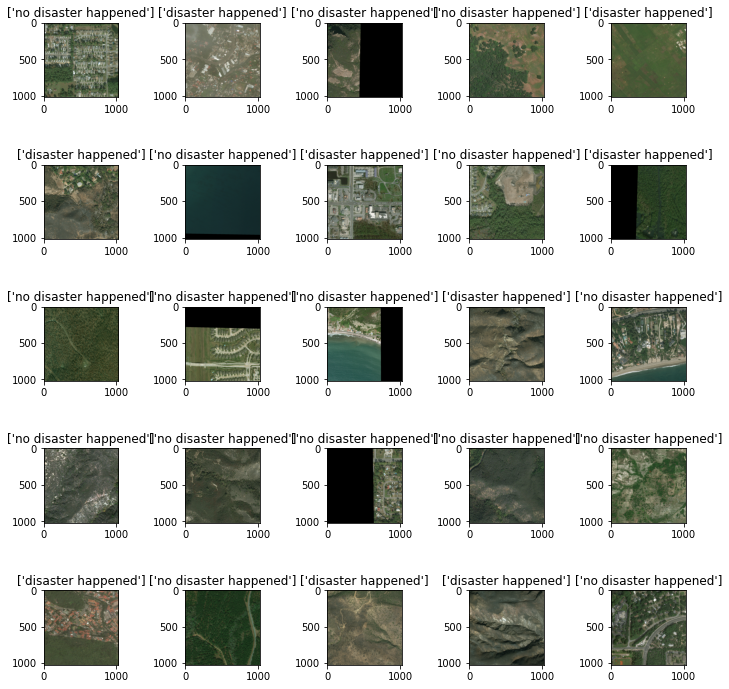

In [ ]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)    
    choice = random.randint(0, train_datasize-1)
    plt.title(get_label_from_one_hot(train_Y[choice]))
    plt.imshow(train_X[choice])

plt.tight_layout()
plt.show()

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation="softmax"),
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 1024, 1024, 3)     0         
                                                                 
 conv2d (Conv2D)             (None, 1024, 1024, 16)    448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 512, 512, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 256, 256, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 64)      1

In [15]:
epochs = 10
batch_size = 5
history = model.fit(
  train_X,
  train_Y,
  validation_data=(test_X, test_Y),
  epochs=epochs,
  batch_size=batch_size
)

Epoch 1/5
300/300 [==============================] - 796s 3s/step - loss: 1.0467 - accuracy: 0.4893 - val_loss: 0.6928 - val_accuracy: 0.5100
Epoch 2/5
300/300 [==============================] - 785s 3s/step - loss: 0.7039 - accuracy: 0.5233 - val_loss: 0.6873 - val_accuracy: 0.5300
Epoch 3/5
300/300 [==============================] - 781s 3s/step - loss: 0.6656 - accuracy: 0.5953 - val_loss: 0.7145 - val_accuracy: 0.5280
Epoch 4/5
300/300 [==============================] - 777s 3s/step - loss: 0.6376 - accuracy: 0.6627 - val_loss: 0.7380 - val_accuracy: 0.4960
Epoch 5/5
300/300 [==============================] - 776s 3s/step - loss: 0.4726 - accuracy: 0.7833 - val_loss: 1.0165 - val_accuracy: 0.5040


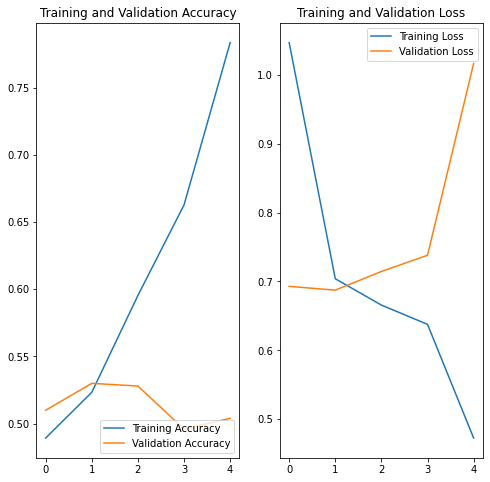

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
model.save("damage-classification-model")

INFO:tensorflow:Assets written to: binary-damage-classification-model/assets


In [18]:
def damage_classification(img):
    print(img.shape)
    image = np.zeros((1, 1024, 1024, 3), dtype=np.uint8)
    image[0] = img
    prediction = model.predict(image).tolist()[0]
    print(prediction)
    return {class_names[i]: prediction[i] for i in range(len(class_names))}

iface = gr.Interface(
    fn = damage_classification,
    inputs = gr.inputs.Image(shape=(1024, 1024), image_mode='RGB', invert_colors=False, source="upload", type='numpy'), 
    outputs = gr.outputs.Label(),
    allow_screenshot=False, 
    allow_flagging='never'
)
iface.launch(share=True, show_error=True, inline=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://24082.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.


(<fastapi.applications.FastAPI at 0x7fe0076c3290>,
 'http://127.0.0.1:7860/',
 'https://24082.gradio.app')